<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [ ]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [1]:
import itertools
import os

from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

In [38]:
# os.chdir("/nas/ucb/ebronstein/deepul/deepul/homeworks/hw1")

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


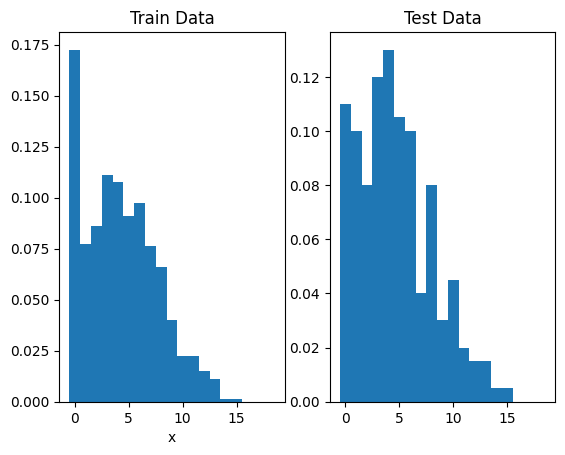

Dataset 2


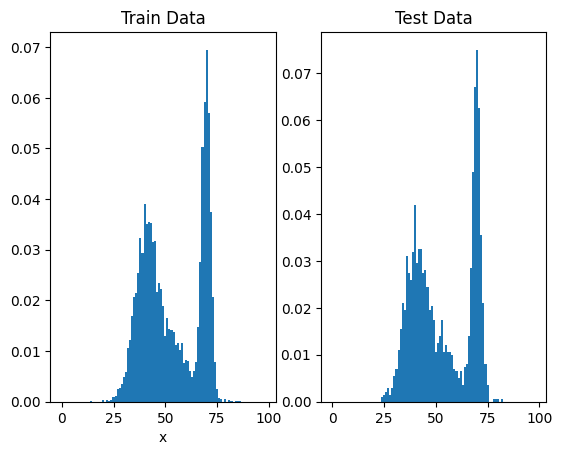

In [7]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{99}) \in \mathbb{R}^{100}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,99\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:
class Histogram(nn.Module):
    def __init__(self, d=30):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d))

    def loss(self, x):
        # Shape: [batch_size, d]
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1)
        return F.cross_entropy(logits, x.long())

    def probabilities(self):
        return F.softmax(self.logits, dim=-1)

In [2]:
def eval(model, dataloader, device="cuda"):
    model = model.to(device)
    model.eval()

    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        loss = model.loss(batch)
        total_loss += loss.item() * batch.shape[0]

    return total_loss / len(dataloader.dataset)


def train(
    model,
    train_dataloader,
    test_dataloader,
    epochs,
    learning_rate,
    device="cuda",
    verbose=False,
):
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    test_losses.append(eval(model, test_dataloader, device))

    for epoch in range(epochs):
        epoch_losses = []
        for batch in train_dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.extend(epoch_losses)
        test_losses.append(eval(model, test_dataloader, device))

        if (epoch + 1) % 10 == 0 and verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

    return train_losses, test_losses


def sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose=False):
    hparams_to_loss = {}

    train_data, test_data = get_data_fn()

    for lr, batch_size, epochs in itertools.product(lrs, batch_sizes, epochs_list):
        print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}")

        train_dataloader = data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        test_dataloader = data.DataLoader(
            test_data, batch_size=batch_size, shuffle=True
        )

        train_losses, test_losses = train(
            model, train_dataloader, test_dataloader, epochs, lr, verbose=verbose
        )
        last_train_loss = train_losses[-1]
        last_test_loss = test_losses[-1]
        hparams_to_loss[(lr, batch_size, epochs)] = (last_train_loss, last_test_loss)

    return hparams_to_loss

In [106]:
dset_id = 1

if dset_id == 1:
    get_data_fn = q1_sample_data_1
elif dset_id == 2:
    get_data_fn = q1_sample_data_2
else:
    raise ValueError("dset_id must be 1 or 2")

d = 100  # For example, 10 bins

# lrs = [0.1, 0.01, 0.001]
# batch_sizes = [32, 64, 128]
# epochs_list = [10, 20, 100]
lrs = [0.1]
batch_sizes = [64]
epochs_list = [20]

verbose = False

model = Histogram(d)
hparams_to_loss = sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose)

Training with lr=0.1, batch_size=64, epochs=20


In [107]:
min(hparams_to_loss, key=lambda x: hparams_to_loss[x][1])

(0.1, 64, 20)

In [10]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    if dset_id == 1:
        learning_rate = 0.1
        batch_size = 64
        epochs = 100
    elif dset_id == 2:
        learning_rate = 0.1
        batch_size = 128
        epochs = 20

    verbose = False

    train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    model = Histogram(d)

    train_losses, test_losses = train(
        model, train_dataloader, test_dataloader, epochs, learning_rate, verbose=verbose
    )
    distribution = model.probabilities().detach().cpu().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5495


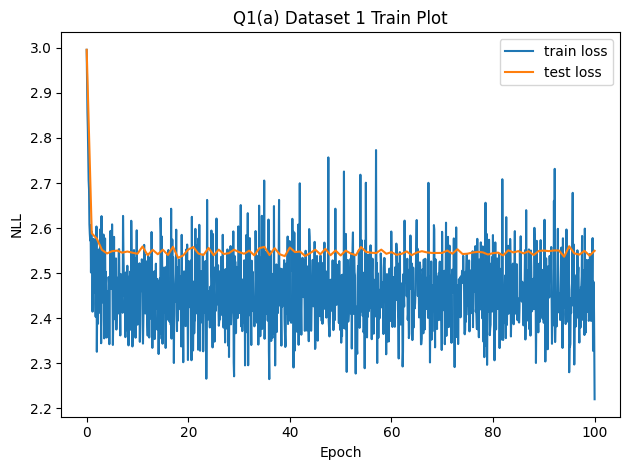

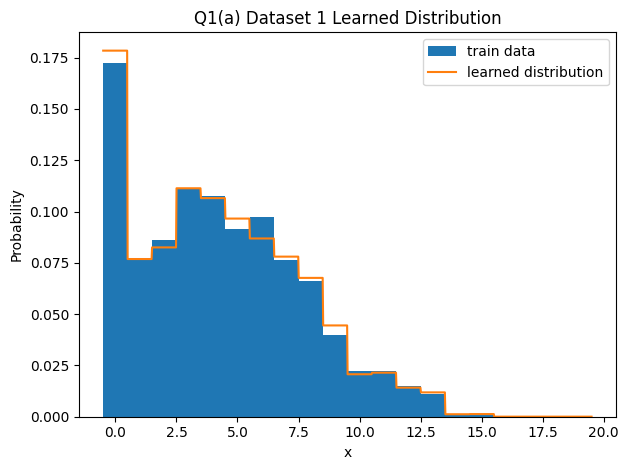

In [84]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 3.6840


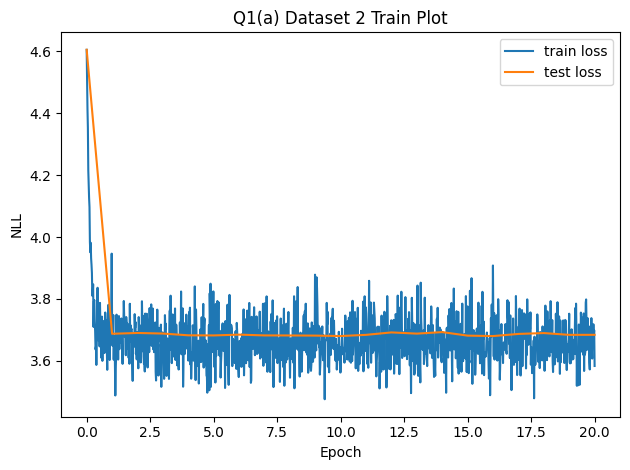

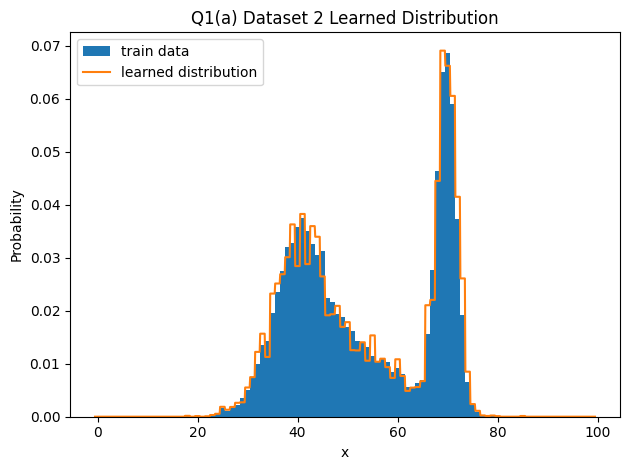

In [85]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [123]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, num_mix=4):
        super().__init__()
        self.d = d
        self.num_mix = num_mix

        # pi_i
        self.logits = nn.Parameter(torch.zeros(num_mix))
        # mu_i
        self.means = nn.Parameter(
            torch.arange(num_mix, dtype=torch.float32) / (num_mix - 1) * d
        )
        # Log of scale s_i
        self.log_scales = nn.Parameter(torch.randn(num_mix))

        # Tolerance for log probability near 0 and d - 1.
        self._log_prob_tol = 1e-3
        # Min value for CDF for numerical stability when taking the log.
        self._cdf_min = 1e-15

    def forward(self, x):
        x = x.float()
        # [batch_size, num_mix]
        x = x.unsqueeze(1).repeat(1, self.num_mix)
        # [1, num_mix]
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
        # 1 / s_i
        inv_scales = torch.exp(-log_scales)

        # CDF of logistics at x + 0.5
        sigmoid_top = torch.sigmoid(inv_scales * (x + 0.5 - means))
        # CDF of logistics at x - 0.5
        sigmoid_bottom = torch.sigmoid(inv_scales * (x - 0.5 - means))
        cdf_delta = sigmoid_top - sigmoid_bottom
        # Log CDF
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=self._cdf_min))

        # Log CDF for x = 0
        log_cdf_min = torch.log(
            torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)), min=self._cdf_min)
        )
        # Log CDF for x = d - 1 = 99
        log_cdf_max = torch.log(
            torch.clamp(
                1 - torch.sigmoid(inv_scales * (self.d - 1 - 0.5 - means)),
                min=self._cdf_min,
            )
        )
        # Replace x = d - 1 with log CDF for x = d - 1
        x_log_probs = torch.where(
            x > self.d - 1 - self._log_prob_tol, log_cdf_max, log_cdf_delta
        )
        # Replace x = 0 with log CDF for x = 0
        x_log_probs = torch.where(x < self._log_prob_tol, log_cdf_min, x_log_probs)
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return torch.logsumexp(log_probs, dim=1)

    def loss(self, x):
        # The forward pass on x returns log probabilities, so we take the mean
        # and negate it to get negative log likelihood loss.
        return -torch.mean(self(x))

    def probabilities(self):
        with torch.no_grad():
            bins = torch.arange(self.d, dtype=torch.float32, device=self.logits.device)
            return torch.exp(self(bins))

In [108]:
get_data_fn = q1_sample_data_1

model = MixtureOfLogistics(d, n_mix=4).cuda()
dset_id = 1
epochs_list = [10, 20]
lrs = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]
hparams_to_loss = sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose)

Training with lr=0.1, batch_size=32, epochs=10
Training with lr=0.1, batch_size=32, epochs=20
Training with lr=0.1, batch_size=64, epochs=10
Training with lr=0.1, batch_size=64, epochs=20
Training with lr=0.1, batch_size=128, epochs=10
Training with lr=0.1, batch_size=128, epochs=20
Training with lr=0.01, batch_size=32, epochs=10
Training with lr=0.01, batch_size=32, epochs=20
Training with lr=0.01, batch_size=64, epochs=10
Training with lr=0.01, batch_size=64, epochs=20
Training with lr=0.01, batch_size=128, epochs=10
Training with lr=0.01, batch_size=128, epochs=20
Training with lr=0.001, batch_size=32, epochs=10
Training with lr=0.001, batch_size=32, epochs=20
Training with lr=0.001, batch_size=64, epochs=10
Training with lr=0.001, batch_size=64, epochs=20
Training with lr=0.001, batch_size=128, epochs=10
Training with lr=0.001, batch_size=128, epochs=20


In [111]:
min(hparams_to_loss, key=lambda x: hparams_to_loss[x][1])

(0.01, 32, 20)

In [121]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    # batch_size = 32
    # epochs = 20
    # lr = 0.01
    batch_size = 128
    epochs = 10
    lr = 1e-1

    model = MixtureOfLogistics(d, num_mix=4).cuda()
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(
        model, train_loader, test_loader, epochs, lr, verbose=True
    )
    distribution = model.probabilities().detach().cpu().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch [10/10], Loss: 2.431654930114746
Final Test Loss: 2.5471


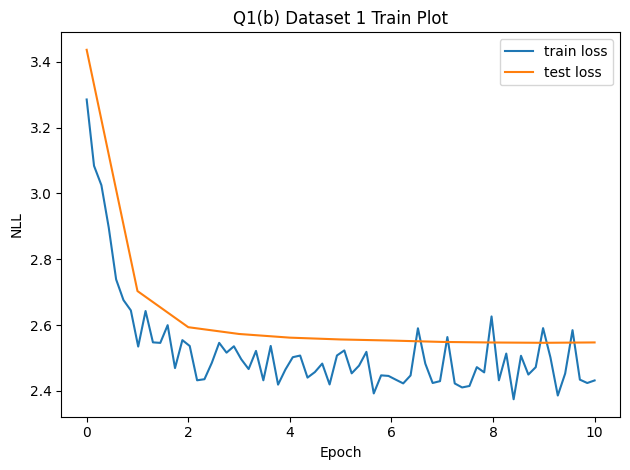

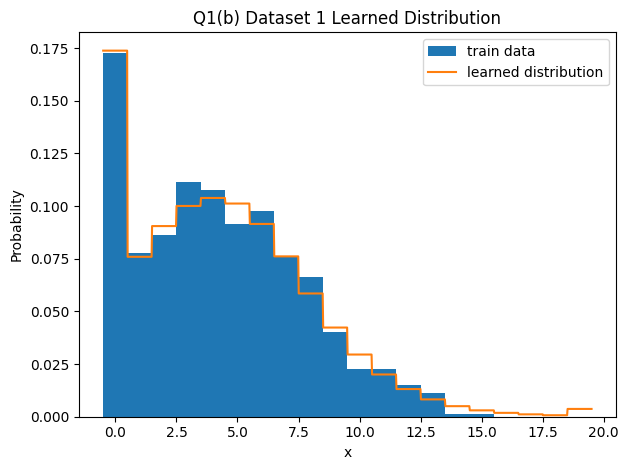

In [124]:
q1_save_results(1, 'b', q1_b)

Epoch [10/10], Loss: 3.692760467529297
Final Test Loss: 3.6946


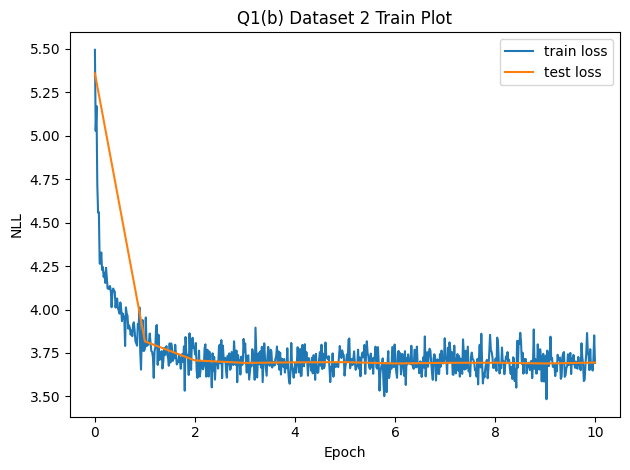

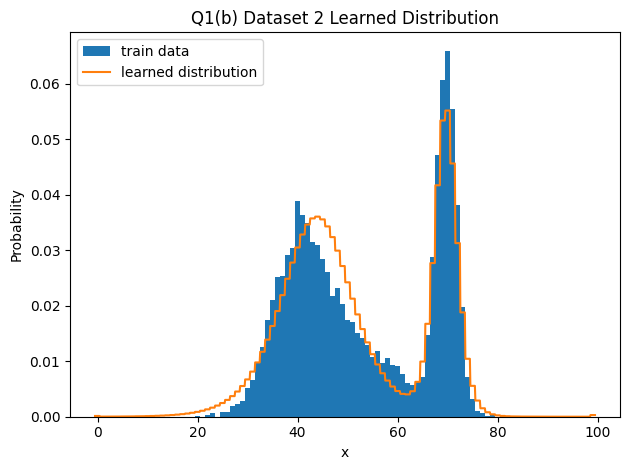

In [125]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

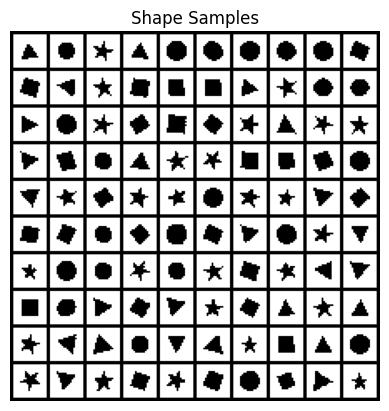

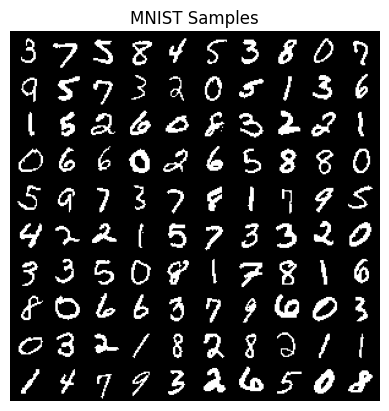

In [3]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from typing import Literal

MaskType = Literal["A", "B"]


class MaskConv2d(nn.Conv2d):
    def __init__(
        self,
        mask_type: MaskType,
        *args,
        color_conditioning=False,
        **kwargs,
    ):
        """2D Convolution with masked weight for AutoRegressive connection.

        Args:
            mask_type: Either "A" or "B". Determines which weights of the filter
                are used in the convolution.
            *args: Forwarded to `nn.Conv2d`.
            color_conditioning: Whether to use color conditioning or not.
            **kwargs: Forwarded to `nn.Conv2d`.
        """
        if mask_type not in ["A", "B"]:
            raise ValueError(f'Invalid mask type "{mask_type}"')

        super().__init__(*args, **kwargs)

        self.color_conditioning = color_conditioning

        # Make the mask a buffer since it's not a trainable parameter.
        # Shape: [out_channels, in_channels, kernel_size[0], kernel_size[1]
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self._create_mask(mask_type)

    def forward(self, x):
        return F.conv2d(
            x,
            self.weight * self.mask,  # Apply the mask to the weights.
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

    def _create_mask(self, mask_type):
        k = self.kernel_size[0]
        # Only allow (context) connections to pixels above and to the right.
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1

        if self.color_conditioning:
            if self.in_channels % 3 != 0:
                raise ValueError(
                    "Color conditioning can only be used when input has 3 channels."
                )
            if self.out_channels % 3 != 0:
                raise ValueError(
                    "Color conditioning can only be used when output has 3 channels."
                )

            one_third_in = self.in_channels // 3
            one_third_out = self.out_channels // 3
            if mask_type == "B":
                # Allow connection from the red channel to the red channel.
                self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
                # Allow connection from the green channel to the red and green
                # channels.
                self.mask[
                    one_third_out : 2 * one_third_out,
                    : 2 * one_third_in,
                    k // 2,
                    k // 2,
                ] = 1
                # Allow connection from the blue channel to the red, green, and
                # blue channels.
                self.mask[2 * one_third_out :, :, k // 2, k // 2] = 1
            else:
                # Allow connection from the green channel to the red channel.
                self.mask[
                    one_third_out : 2 * one_third_out, :one_third_in, k // 2, k // 2
                ] = 1
                # Alllow connection from the blue channel to the red and green
                # channels.
                self.mask[2 * one_third_out :, : 2 * one_third_in, k // 2, k // 2] = 1
        else:
            if mask_type == "B":
                # Allow connection from a channel to itself.
                self.mask[:, :, k // 2, k // 2] = 1


class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.block = nn.ModuleList(
            [
                nn.ReLU(),
                MaskConv2d("B", in_channels, in_channels // 2, 1, **kwargs),
                nn.ReLU(),
                # Use 7x7 convolution instead of 3x3 convolution (as in the original paper).
                MaskConv2d(
                    "B", in_channels // 2, in_channels // 2, 7, padding=3, **kwargs
                ),
                nn.ReLU(),
                MaskConv2d("B", in_channels // 2, in_channels, 1, **kwargs),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.block:
            out = layer(out)
        return out + x


class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color_conditioning = color_conditioning

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        if self.color_conditioning:
            x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color_conditioning:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()


class PixelCNN(nn.Module):
    def __init__(
        self,
        shape,
        num_colors,
        num_filters=64,
        kernel_size=7,
        num_layers=5,
        use_resblock=False,
        color_conditioning=False,
    ):
        """Initialize PixelCNN model.

        Args:
            shape: Shape of the input data in the order [num_channels, height, width].
            num_colors: Number of color categories in each channel. This is the
                number of colors that the dataset is quantized into. For example,
                if num_colors=4, then there are 4 colors and 2 bits per channel.
            num_filters: Number of convolutional filters.
            kernel_size: Kernel size for initial convolutional layers.
            num_layers: Number of masked type B convolutional layers.
            use_resblock: Whether to use ResBlocks instead of MaskedConv2d.
            color_conditioning: Whether to use color conditioning or not.
        """
        super().__init__()

        self.shape = shape
        self.num_colors = num_colors
        self.num_channels = shape[0]
        self.color_conditioning = color_conditioning

        if use_resblock:
            block_init = lambda: ResBlock(
                num_filters, color_conditioning=color_conditioning
            )
        else:
            block_init = lambda: MaskConv2d(
                "B",
                num_filters,
                num_filters,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                color_conditioning=color_conditioning,
            )

        model = nn.ModuleList(
            [
                MaskConv2d(
                    "A",
                    self.num_channels,
                    num_filters,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                    color_conditioning=color_conditioning,
                )
            ]
        )
        for _ in range(num_layers):
            if color_conditioning:
                model.append(LayerNorm(color_conditioning, num_filters // 3))
            else:
                model.append(LayerNorm(color_conditioning, num_filters))
            model.extend([nn.ReLU(), block_init()])
        model.extend(
            [
                nn.ReLU(),
                MaskConv2d(
                    "B",
                    num_filters,
                    num_filters,
                    1,
                    color_conditioning=color_conditioning,
                ),
            ]
        )
        model.extend(
            [
                nn.ReLU(),
                MaskConv2d(
                    "B",
                    num_filters,
                    num_colors * self.num_channels,
                    1,
                    color_conditioning=color_conditioning,
                ),
            ]
        )

        self.net = model

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() / (self.num_colors - 1) - 0.5) / 0.5
        for layer in self.net:
            out = layer(out)

        if self.color_conditioning:
            # Shape: [batch_size, num_colors, num_channels, height, width]
            return out.view(
                batch_size, self.num_channels, self.num_colors, *self.shape[1:]
            ).permute(0, 2, 1, 3, 4)
        else:
            # Shape: [batch_size, num_colors, height, width]
            return out.view(batch_size, self.num_colors, *self.shape)

    def loss(self, x):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        """Samples `n` images from the model.
        Args:
            n: Number of images to sample.

        Returns:
            Samples of shape [n, height, width, num_channels].
        """
        # Shape: [n, num_channels, height, width]
        samples = torch.zeros(n, *self.shape).cuda()
        with torch.no_grad():
            for r in range(self.shape[1]):
                for c in range(self.shape[2]):
                    for k in range(self.num_channels):
                        logits = self(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [5]:
def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W = image_shape
    model = PixelCNN((1, H, W), 2, num_layers=5).cuda()

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train(model, train_loader, test_loader, 10, 1e-3)
    samples = model.sample(100)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.0396


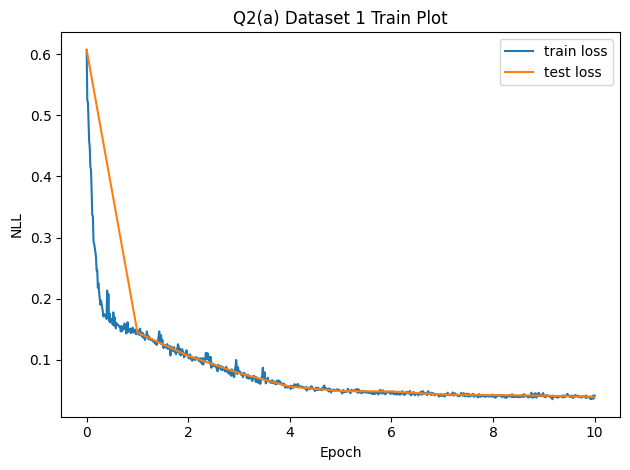

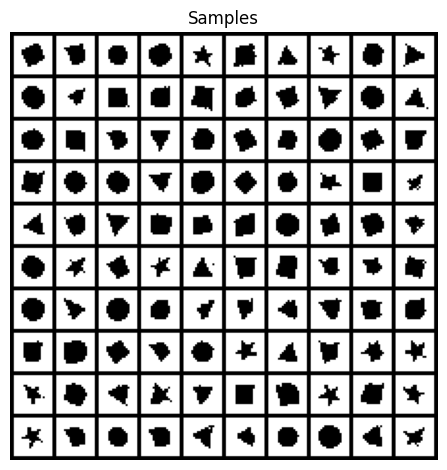

In [31]:
q2a_save_results(1, q2_a)

Final Test Loss: 0.0757


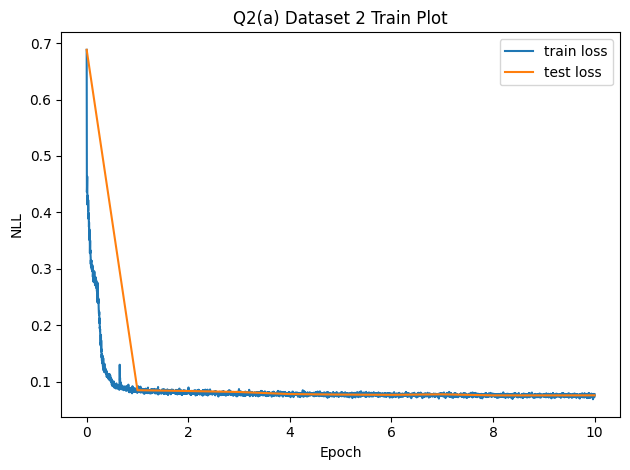

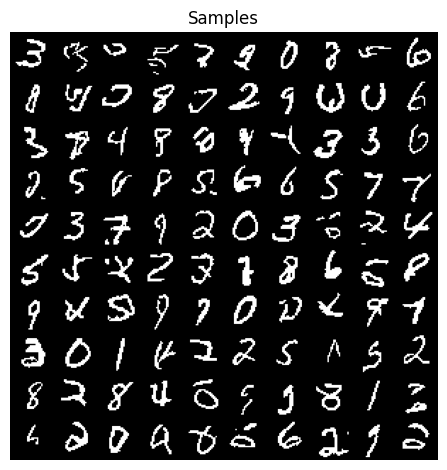

In [6]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

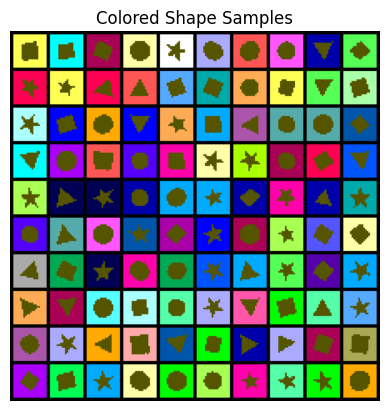

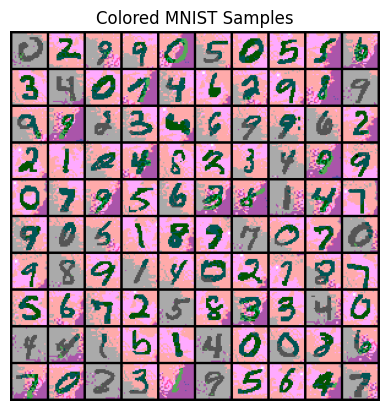

In [32]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [34]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    # Reshape to [batch_size, C, H, W] for PixelCNN/Conv2D compatibility.
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W, C = image_shape
    num_colors = 4
    epochs = 15
    lr = 1e-3
    num_filters = 120
    num_layers = 8
    batch_size = 128
    model = PixelCNN(
        (C, H, W),
        num_colors,
        num_filters=num_filters,
        num_layers=num_layers,
        use_resblock=True,
    ).cuda()

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, epochs, lr)
    samples = model.sample(100)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0425


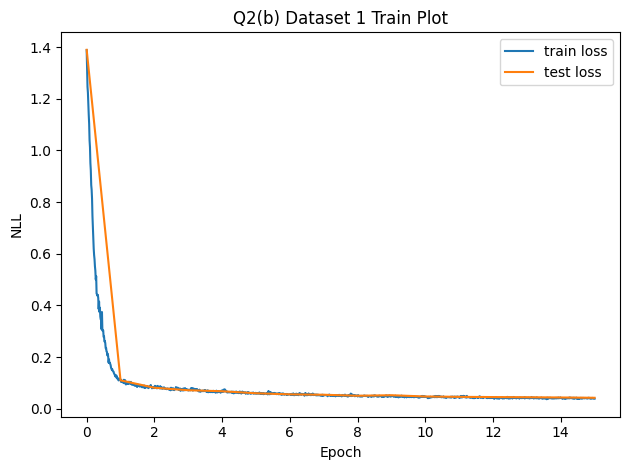

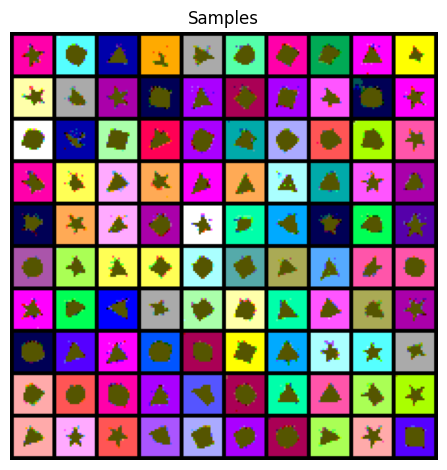

In [35]:
q2b_save_results(1, 'b', q2_b)

Final Test Loss: 0.0892


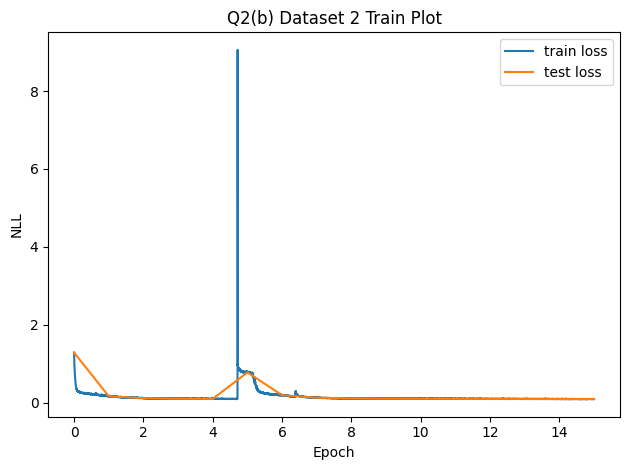

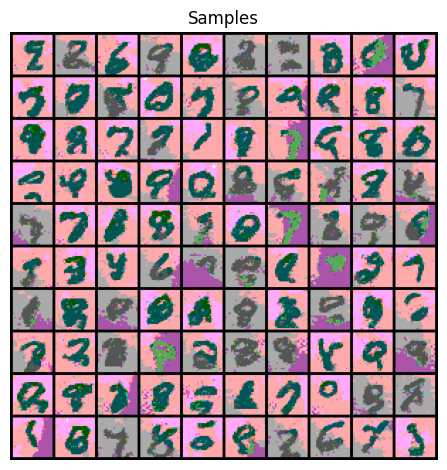

In [36]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. Use those here as well.
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'a', q3_a)

In [ ]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST: Independent Color Channels

Now, implement an iGPT that models color channels (Like Question 2(b) except with the Transformer). In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'b', q3_b)

In [ ]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  return autoencoded_images

In [ ]:
q4a_save_results(1, q4_a)

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST: Independent Color Channels with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

In [ ]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [ ]:
q6a_save_results(q6_a)